In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [3]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

In [8]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=True)

# Training

iter 1: 0.184915
iter 2: 0.134531
iter 3: 0.0904143
iter 4: 0.083056
iter 5: 0.0716947
iter 6: 0.0618579
iter 7: 0.0561775
iter 8: 0.0511473
iter 9: 0.0461612
iter 10: 0.0367779
iter 11: 0.034263
iter 12: 0.0317064
iter 13: 0.03359
iter 14: 0.0347193
iter 15: 0.0220893
iter 16: 0.0249806
iter 17: 0.0248289
iter 18: 0.0198335
iter 19: 0.0154178
iter 20: 0.0180214
iter 21: 0.0233419
iter 22: 0.0268302
iter 23: 0.019242
iter 24: 0.0191363
iter 25: 0.0183929
iter 26: 0.0202482
iter 27: 0.0167606
iter 28: 0.0132589
iter 29: 0.0106555
iter 30: 0.0133541
iter 31: 0.0116475
iter 32: 0.0118922
iter 33: 0.0131865
iter 34: 0.0104832
iter 35: 0.00973201
iter 36: 0.0108173
iter 37: 0.0138121
iter 38: 0.015639
iter 39: 0.0104089
iter 40: 0.0155778
iter 41: 0.0141779
iter 42: 0.0124885
iter 43: 0.0120339
iter 44: 0.0120428
iter 45: 0.0131973
iter 46: 0.00886191
iter 47: 0.0129546
iter 48: 0.0140278
iter 49: 0.00839757
iter 50: 0.0124098
iter 51: 0.0156274
iter 52: 0.00720676
iter 53: 0.0211354
iter 5

iter 406: 0.00316992
iter 407: 0.006541
iter 408: 0.00509776
iter 409: 0.0054596
iter 410: 0.00479559
iter 411: 0.00729524
iter 412: 0.00589694
iter 413: 0.00580381
iter 414: 0.0103449
iter 415: 0.00344032
iter 416: 0.00533785
iter 417: 0.00785246
iter 418: 0.00717331
iter 419: 0.00551495
iter 420: 0.0067702
iter 421: 0.00882953
iter 422: 0.00419676
iter 423: 0.00437439
iter 424: 0.00639625
iter 425: 0.00780472
iter 426: 0.0034496
iter 427: 0.00541194
iter 428: 0.00703298
iter 429: 0.00279538
iter 430: 0.00363949
iter 431: 0.00595083
iter 432: 0.00320357
iter 433: 0.00348519
iter 434: 0.00704942
iter 435: 0.00425624
iter 436: 0.00537662
iter 437: 0.00684459
iter 438: 0.00387368
iter 439: 0.0079477
iter 440: 0.00790506
iter 441: 0.00302412
iter 442: 0.00536959
iter 443: 0.00535368
iter 444: 0.00680394
iter 445: 0.0049753
iter 446: 0.00444042
iter 447: 0.00533577
iter 448: 0.00495577
iter 449: 0.0075887
iter 450: 0.00354105
iter 451: 0.00862972
iter 452: 0.0062567
iter 453: 0.0076925
ite

iter 801: 0.0070728
iter 802: 0.00580107
iter 803: 0.00356996
iter 804: 0.00586062
iter 805: 0.0057798
iter 806: 0.00620789
iter 807: 0.00532441
iter 808: 0.00266602
iter 809: 0.00482322
iter 810: 0.0038715
iter 811: 0.00697052
iter 812: 0.00686851
iter 813: 0.00358097
iter 814: 0.00483057
iter 815: 0.00498594
iter 816: 0.0034562
iter 817: 0.00675871
iter 818: 0.00449381
iter 819: 0.00404226
iter 820: 0.00481979
iter 821: 0.00428745
iter 822: 0.00461303
iter 823: 0.00951441
iter 824: 0.00461764
iter 825: 0.00335584
iter 826: 0.00409527
iter 827: 0.00531593
iter 828: 0.00485099
iter 829: 0.00434029
iter 830: 0.0046199
iter 831: 0.00460676
iter 832: 0.00461046
iter 833: 0.00365154
iter 834: 0.00725201
iter 835: 0.00616909
iter 836: 0.00643991
iter 837: 0.00757836
iter 838: 0.00752377
iter 839: 0.00689429
iter 840: 0.00636174
iter 841: 0.00545252
iter 842: 0.00395817
iter 843: 0.00700661
iter 844: 0.00757785
iter 845: 0.00639046
iter 846: 0.00408074
iter 847: 0.00609924
iter 848: 0.004625

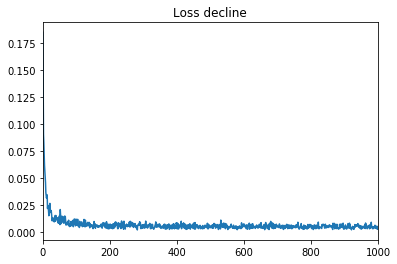

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]

threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

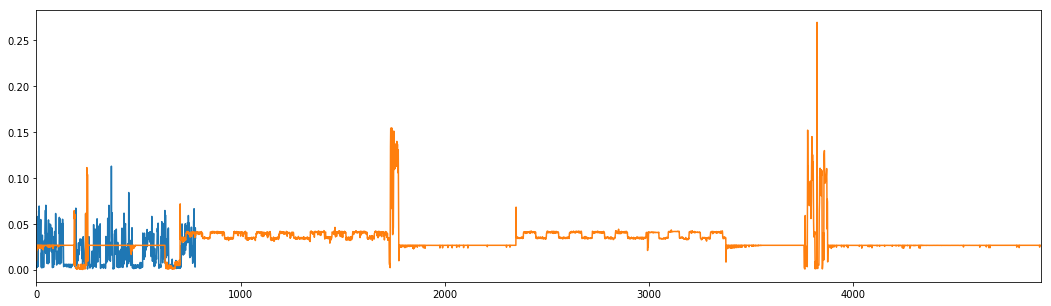

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

In [14]:
beta = 0.1
tp = np.array(abnormal_score)[abnormal_score>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[normal_score>threshold].size
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9629517114840641

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt
Model restored.
Initialized
Predict result :


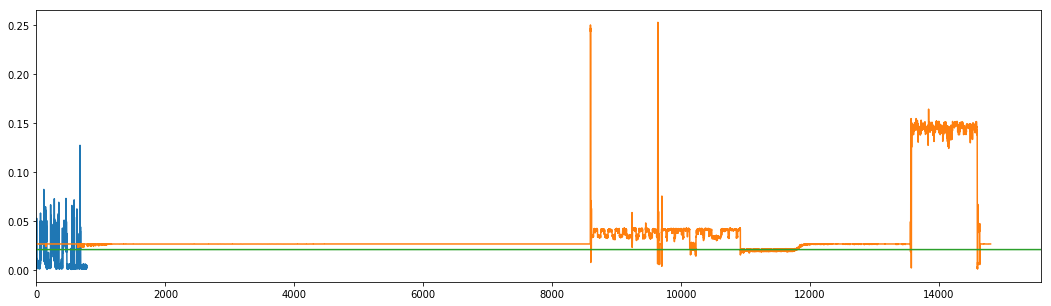

In [15]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [16]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9506570978479527

In [17]:
print(tp,fp,tn,fn,P,R)

14065 735 547 233 0.9503378378378379 0.9837040145474891
